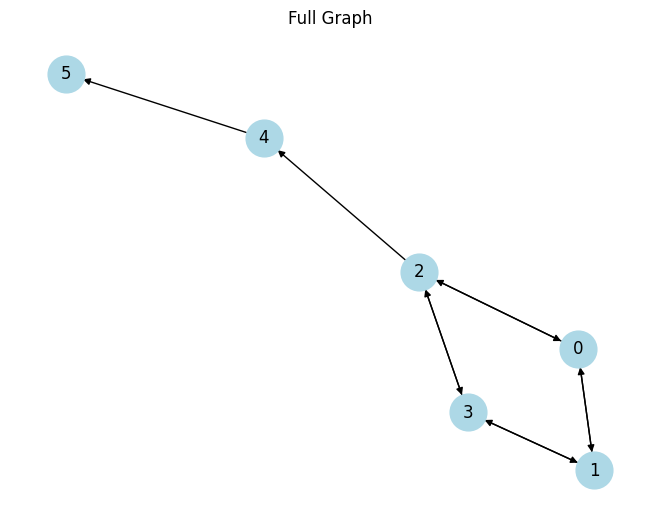

In [44]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import NeighborLoader
import networkx as nx
import matplotlib.pyplot as plt

# 3. Graph visualization helper
def visualize_graph(edge_index, title, labels=None):
    G = nx.DiGraph()
    edges = edge_index.t().tolist()
    G.add_edges_from(edges)
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, labels=labels,
            node_color="lightblue", node_size=700, font_size=12, arrows=True)
    plt.title(title)
    plt.show()

# A more interesting graph
# 0 -> 1, 2
# 1 -> 3
# 2 -> 3, 4
# 4 -> 5
edge_index = torch.tensor([
    [0, 0, 1, 2, 2, 4],
    [1, 2, 3, 3, 4, 5]
], dtype=torch.long)

edge_index = torch.tensor([
    [0, 1, 0, 2, 1, 3, 2, 3, 2, 4],
    [1, 0, 2, 0, 3, 1, 3, 2, 4, 5]
], dtype=torch.long)

y = torch.tensor([0, 1, 0, 1, 0, 1])  # Labels (for classification)

train_mask = torch.tensor([1, 1, 1, 0, 0, 0], dtype=torch.bool)

data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask)

# 4. Visualize the original full graph
visualize_graph(data.edge_index, "Full Graph")

In [45]:
print(x)

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.]])


In [46]:
print(edge_index)

tensor([[0, 1, 0, 2, 1, 3, 2, 3, 2, 4],
        [1, 0, 2, 0, 3, 1, 3, 2, 4, 5]])


In [47]:
print(y)

tensor([0, 1, 0, 1, 0, 1])


In [48]:
print(train_mask)

tensor([ True,  True,  True, False, False, False])


In [49]:
print(data)

Data(x=[6, 1], edge_index=[2, 10], y=[6], train_mask=[6])


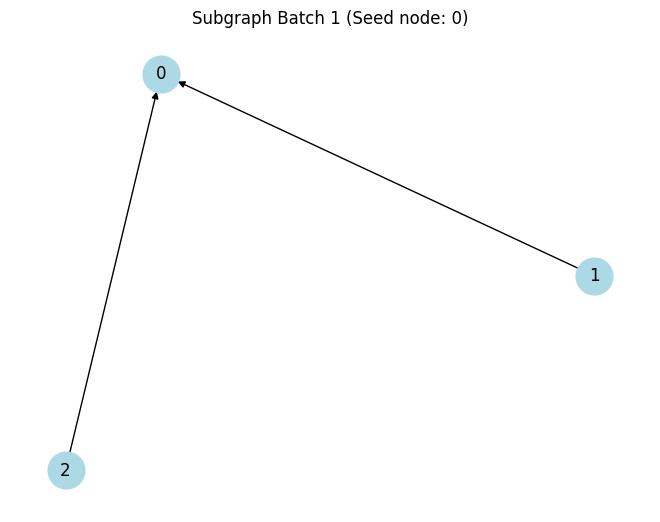

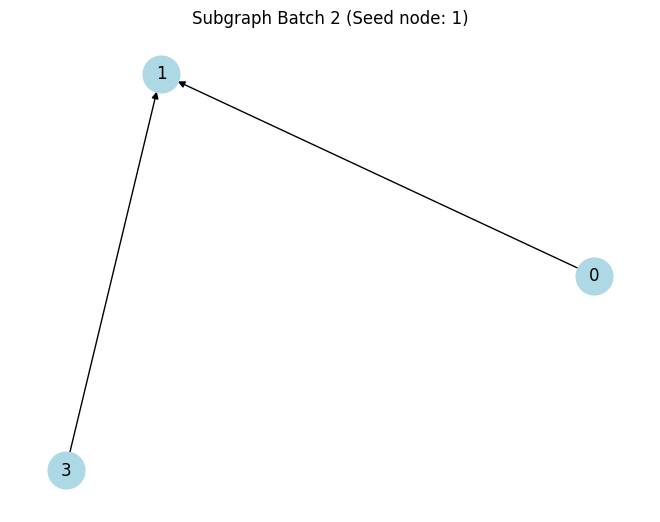

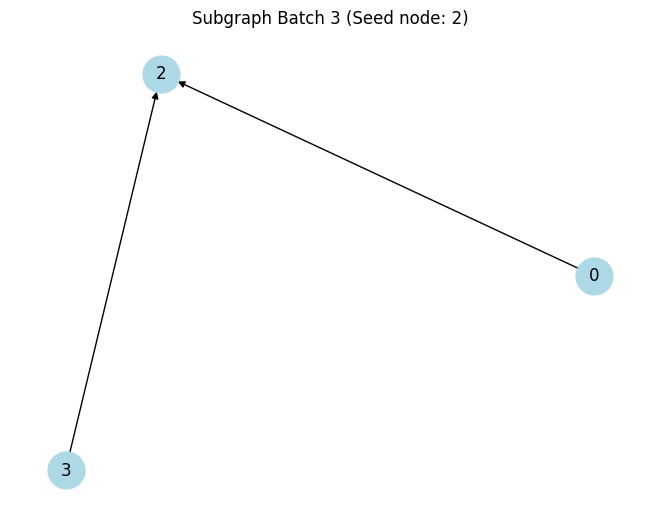

In [65]:
loader = NeighborLoader(
    data,
    input_nodes=data.train_mask,     # Only nodes 0 and 1
    num_neighbors=[2],               # Sample up to 2 neighbors per node (1-hop only)
    batch_size=1,                    # One seed node per batch
    shuffle=False
)

# Use a 2-hop neighborhood to ensure richer subgraphs
loader = NeighborLoader(
    data,
    input_nodes=data.train_mask,
    num_neighbors=[2],  # 2 neighbors per hop, for 2 hops
    batch_size=1,
    shuffle=False
)

def visualize_graph(edge_index, title, labels):
    G = nx.DiGraph()

    # Always add nodes explicitly
    G.add_nodes_from(labels.keys())

    # Then add edges if any exist
    if edge_index.numel() > 0:
        edges = edge_index.t().tolist()
        G.add_edges_from(edges)

    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, labels=labels,
            node_color="lightblue", node_size=700, font_size=12, arrows=True)
    plt.title(title)
    plt.show()
    
# 5. Visualize subgraphs from NeighborLoader batches
# Visualize first few sampled subgraphs
for i, batch in enumerate(loader):
    global_node_ids = batch.n_id.tolist()
    label_map = {local_id: str(global_id) for local_id, global_id in enumerate(global_node_ids)}

    visualize_graph(batch.edge_index, f"Subgraph Batch {i+1} (Seed node: {batch.input_id.tolist()[0]})", labels=label_map)

    if i >= 2:
        pass #break

In [67]:
batch = next(iter(loader))
print(batch)
print(batch.x)
print(batch.edge_index)
print(batch.y)
print(batch.train_mask)
print(batch.n_id)
print(batch.e_id)
print(batch.input_id)
print(batch.batch)

Data(x=[3, 1], edge_index=[2, 2], y=[3], train_mask=[3], n_id=[3], e_id=[2], input_id=[1], batch_size=1)
tensor([[0.],
        [1.],
        [2.]])
tensor([[1, 2],
        [0, 0]])
tensor([0, 1, 0])
tensor([True, True, True])
tensor([0, 1, 2])
tensor([1, 3])
tensor([0])
None


In [12]:
print("batch.x:", batch.x.squeeze())            # e.g., tensor([0., 1.])
print("batch.y:", batch.y)                      # labels for those nodes
print("batch.edge_index:\n", batch.edge_index)  # remapped edge indices
print("batch.batch:", batch.batch)              # maps to seed node

batch.x: tensor(0.)
batch.y: tensor([0])
batch.edge_index:
 tensor([], size=(2, 0), dtype=torch.int64)
batch.batch: None


In [69]:
#!pip install torch-geometric

import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.data import Data
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import GCNConv

# --- Build Toy Graph ---
edge_index = torch.tensor([
    [0, 0, 1, 1, 2, 2, 3, 4],
    [1, 2, 3, 4, 3, 5, 5, 5]
], dtype=torch.long)

x = torch.randn((6, 8))  # 6 nodes with 8 features
y = torch.tensor([0, 1, 0, 1, 0, 1])  # labels
train_mask = torch.tensor([1, 1, 1, 0, 0, 0], dtype=torch.bool)

data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask)

# --- Define GCN Model ---
class GCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

model = GCN(in_dim=8, hidden_dim=16, out_dim=2)

# --- Use NeighborLoader ---
loader = NeighborLoader(
    data,
    input_nodes=data.train_mask,
    num_neighbors=[10, 10],
    batch_size=2,
    shuffle=True
)

# --- Train for 1 Epoch ---
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

for i, batch in enumerate(loader):
    optimizer.zero_grad()

    out = model(batch.x, batch.edge_index)

    # Get seed node indices (map global ID → local index in batch.n_id)
    seed_global_ids = batch.input_id
    seed_local_indices = [(batch.n_id == sid).nonzero(as_tuple=True)[0].item() for sid in seed_global_ids]

    out_seed = out[seed_local_indices]
    y_seed = batch.y[seed_local_indices]

    loss = F.cross_entropy(out_seed, y_seed)
    loss.backward()
    optimizer.step()

    print(f"Batch {i+1}: Seed nodes = {seed_global_ids.tolist()}, Loss = {loss.item():.4f}")
    if i >= 2: break


Batch 1: Seed nodes = [1, 0], Loss = 0.7738
Batch 2: Seed nodes = [2], Loss = 0.5441
